In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, seaborn as sns, astropy, matplotlib as mpl
from matplotlib.lines import Line2D
from gdpyc import GasMap
from astropy.io import ascii as ascii_io
from astropy.coordinates import SkyCoord

plt.rcParams["font.size"] = "20"

In [2]:
BeSS = ascii_io.read("../catalogs/BeSS_catalog.csv", format="csv", header_start=0, data_start=1)
BeSS = BeSS.to_pandas()
total = BeSS.drop(['Category', 'V', 'Nb of spectra in BeSS', 'vsini'],axis=1).copy()

In [3]:
def dupe_remove(df,idcol="#",target="angDist"):
    for i in df[idcol]:
        instances = len(df[df[idcol]==i])
        if instances == 0:
            pass
        elif instances >= 2:
            dupeframe = df[df[idcol]==i][[idcol,target]]
            df.drop(dupeframe[dupeframe[target]>min(dupeframe[target])].index, inplace=True)

In [4]:
for xmatch in ["gaiaedr3","gedr3dis","simbad","csc2master","xmm4dr9s"]:
    working = pd.read_csv("./BeSS_xmatches_sparse/"+xmatch+".csv")
    print(xmatch,len(working),end=" -> ")
    dupe_remove(working)
    print(len(working))
    total = total.merge(working.drop(["angDist"],axis=1),on="#",how="left")
    assert len(total)==len(BeSS)

gaiaedr3 1984 -> 1978
gedr3dis 1928 -> 1927
simbad 2202 -> 2109
csc2master 61 -> 59
xmm4dr9s 69 -> 69


In [ ]:
total["N_H"] = GasMap.nh(SkyCoord(ra=total["RA"], dec=total["DEC"], unit=(u.hourangle,u.deg)))

In [6]:
for i in total.index:
    if pd.isna(total.loc[i,"2CXO"]) and pd.isna(total.loc[i,"4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia only"
    elif pd.isna(total.loc[i,"2CXO"]):
        total.loc[i,"Catalog membership"] = "Gaia,XMM"
    elif pd.isna(total.loc[i,"4XMM"]):
        total.loc[i,"Catalog membership"] = "Gaia,Chandra"
    else:
        total.loc[i,"Catalog membership"] = "Gaia,Chandra,XMM"

for i in total.index:
    if total.loc[i,"main_type"] in ["Ae*","Be*","*","Em*","Star",'*  ','~  ', "s*b","IR","HII","sg*","SG*","post-AGB*","RB?","Candidate_Be*","Candidate_RGB*","BlueSG*","Radio","Radio(sub-mm)","Cl*"]:
        #total.drop(i, axis=0, inplace=True)
        continue
    elif total.loc[i,"main_type"] in ["Al*","EB*","SB*","** ","**","WU*","bL*","*in**",'EB*WUMa', 'EB*betLyr','EB*Algol',"multiple_object"]:
        total.loc[i,"Class"] = "Binary"
    elif total.loc[i,"main_type"] in ["Pe*","WR*","Pec*"]:
        total.loc[i,"Class"] = "Peculiar/WR"
    elif total.loc[i,"main_type"] in ["Y*?", "Y*O","Candidate_YSO","YSO"]:
        total.loc[i,"Class"] = "YSO"
    elif total.loc[i,"main_type"] in ["*iN","pA*","*inNeb","RfNeb"]:
        total.loc[i,"Class"] = "Nebular"
    elif total.loc[i,"main_type"] in ["Eruptive*","Er*","Orion_V*","Pu*","V* ",'a2*','bC*',"V*","PulsV*bCep","PulsV*","RotV*alf2CVn"]:
        total.loc[i,"Class"] = "Variable"
    elif total.loc[i,"main_type"] in ["HXB","HMXB"]:
        total.loc[i,"Class"] = "XRB"

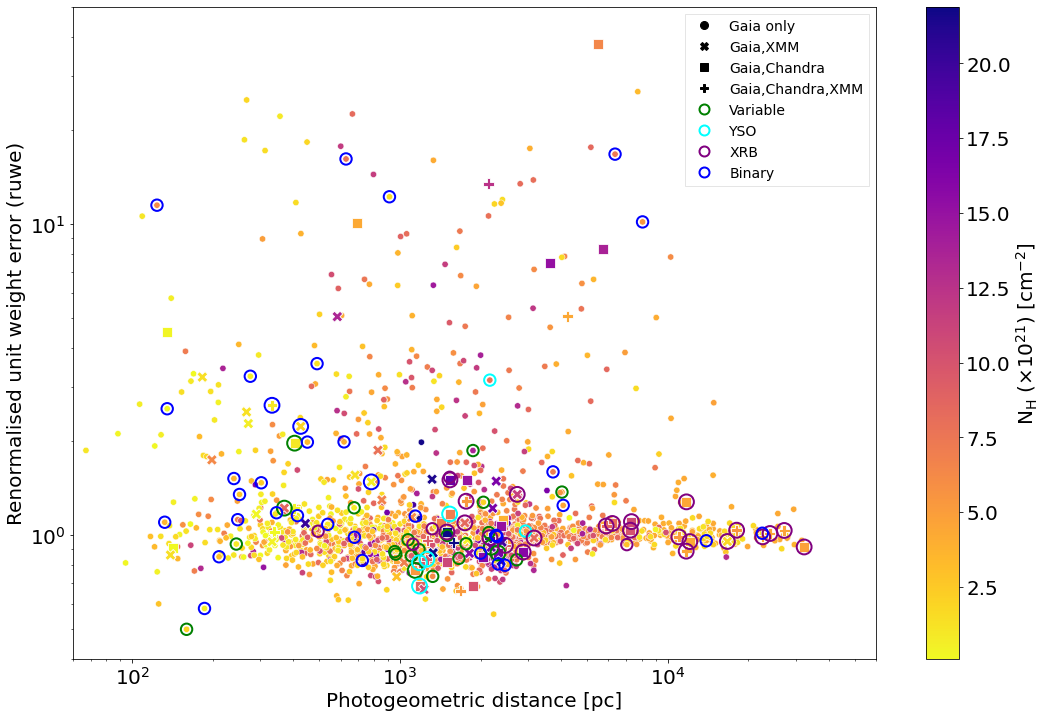

In [7]:
fig, ax = plt.subplots(figsize=(18,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

markers = {"Gaia only":"o","Gaia,XMM":"X","Gaia,Chandra":"s","Gaia,Chandra,XMM":"P"}
colors = {"Variable":"g","YSO":"cyan","XRB":"purple","Binary":"b"}
sizes = dict(zip(markers.keys(), [40,120,100,120]))
for cat, frame in total.groupby("Catalog membership"):
    sns.scatterplot(data=total[total["N_H"].isna() & (total["Catalog membership"]==cat)], x="rpgeo", y="ruwe",
                    color="grey", marker=markers[cat], s=sizes[cat], ax=ax, legend=True)
    sns.scatterplot(data=total[~total["N_H"].isna() & (total["Catalog membership"]==cat)],x="rpgeo",y="ruwe",
                    hue="N_H",palette="plasma_r",marker=markers[cat],s=sizes[cat],ax=ax, legend=True)

for cls in ["Variable","YSO","XRB","Binary"]:
    working = total[total["Class"]==cls]
    ax.scatter(working["rpgeo"], working["ruwe"],
               s=[130 if working["Catalog membership"][i]=="Gaia only" else 220 for i in working.index],
               linewidth=2, facecolors='none', edgecolors=colors[cls], label=cls)

ax.set(xlim=(60,60000), ylim=(0.4,50), xscale="log", yscale="log",
       xlabel="Photogeometric distance [pc]",ylabel="Renormalised unit weight error (ruwe)")

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=total["N_H"].min()/1e21,vmax=total["N_H"].max()/1e21, clip=False),
                                   cmap='plasma_r'), label='N$_\mathrm{H}$ (×$10^{21}$) [cm$^{-2}$]',ax=ax)

legend_elements = [Line2D([0], [0], linestyle="", marker=mark, color="k", label=lbl, markersize=8) for lbl,mark in markers.items()]+\
                  [Line2D([0], [0], linestyle="", marker='o', mfc="none", mec=colors[cls], label=cls, markersize=10, mew=2) for cls in colors.keys()
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='ruwe>2, d<1 kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper right', fancybox=False, framealpha=0.5, fontsize=14)#, bbox_to_anchor=(1.15,1))


#fig.savefig("../plots/gaia_ruwe_vs_rpgeo.png",bbox_inches="tight",dpi=300,facecolor="white",transparent=False)

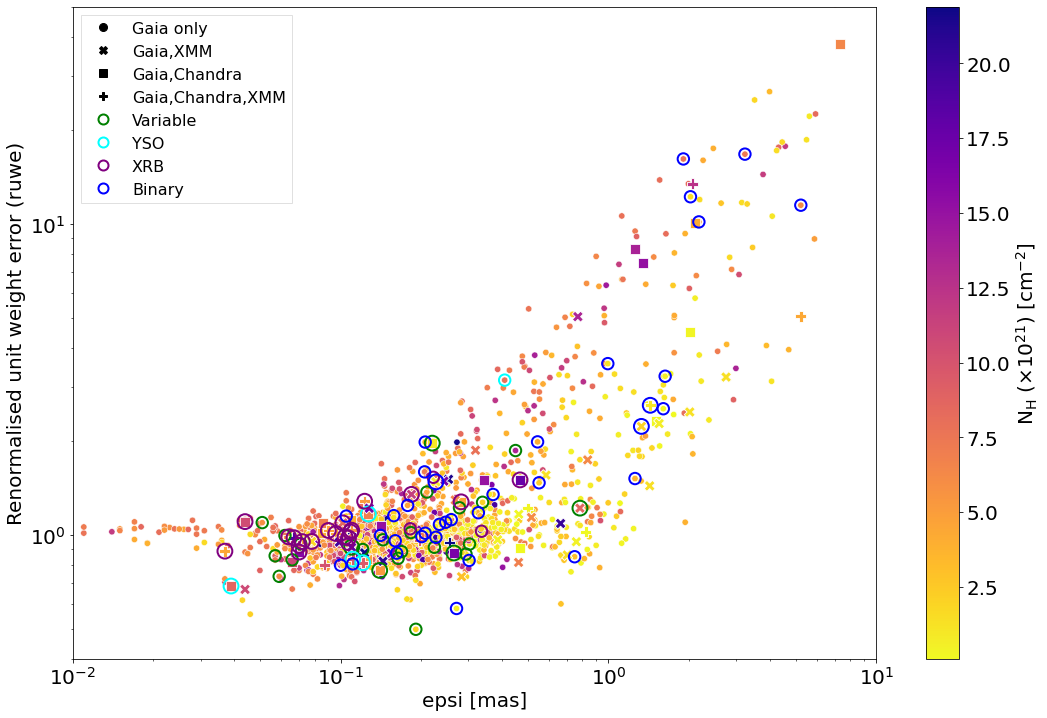

In [8]:
fig, ax = plt.subplots(figsize=(18,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")


markers = {"Gaia only":"o","Gaia,XMM":"X","Gaia,Chandra":"s","Gaia,Chandra,XMM":"P"}
colors = {"Variable":"g","YSO":"cyan","XRB":"purple","Binary":"b"}
sizes = dict(zip(markers.keys(), [40,120,100,120]))
for cat, frame in total.groupby("Catalog membership"):
    sns.scatterplot(data=total[total["N_H"].isna() & (total["Catalog membership"]==cat)], x="epsi", y="ruwe",
                    color="grey", marker=markers[cat], s=sizes[cat], ax=ax, legend=True)
    sns.scatterplot(data=total[~total["N_H"].isna() & (total["Catalog membership"]==cat)],x="epsi",y="ruwe",
                    hue="N_H",palette="plasma_r",marker=markers[cat],s=sizes[cat],ax=ax, legend=True)

for cls in ["Variable","YSO","XRB","Binary"]:
    working = total[total["Class"]==cls]
    ax.scatter(working["epsi"], working["ruwe"],
               s=[130 if working["Catalog membership"][i]=="Gaia only" else 220 for i in working.index],
               linewidth=2, facecolors='none', edgecolors=colors[cls], label=cls)

ax.set(xlim=(0.01,10), ylim=(0.4,50), xscale="log", yscale="log",
       xlabel="epsi [mas]",ylabel="Renormalised unit weight error (ruwe)")
 
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=total["N_H"].min()/1e21,vmax=total["N_H"].max()/1e21, clip=False),
                                   cmap='plasma_r'), label='N$_\mathrm{H}$ (×$10^{21}$) [cm$^{-2}$]',ax=ax)

legend_elements = [Line2D([0], [0], linestyle="", marker=mark, color="k", label=lbl, markersize=8) for lbl,mark in markers.items()]+\
                  [Line2D([0], [0], linestyle="", marker='o', mfc="none", mec=colors[cls], label=cls, markersize=10, mew=2) for cls in colors.keys()]

legend = ax.legend(handles=legend_elements, loc='upper left', fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))